# Analysis of injective flow results

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import torch
from pathlib import Path

from ciflows.flows import plInjFlowModel, TwoStageTraining
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import seaborn as sns 
import logging
from pathlib import Path
import math
import lightning as pl
import normflows as nf
import numpy as np
import torch
import torch.nn as nn
from lightning.pytorch.callbacks import ModelCheckpoint
from normflows.flows.affine import GlowBlock
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

from ciflows.flows.glow import InjectiveGlowBlock, Squeeze, Injective1x1Conv
from ciflows.flows import TwoStageTraining, plInjFlowModel

## Inspect Reconstructions

In [114]:
from ciflows.datasets.mnist import MNISTDataModule

root = Path('/Users/adam2392/pytorch_data/ciflows/vae/results/')

# Set up training configurations
batch_size = 16
num_workers = 8
shuffle = True

# define the data loader
data_module = MNISTDataModule(
    data_dir=root,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)
data_module.setup('train')

In [194]:
dloader = data_module.train_dataloader()
samples, classes = next(iter(dloader))   
print(samples.shape)


# fig, axes = plt.subplots(4, 4, figsize=(8, 8))
# for i in range(batch_size):
#     ax = axes[i // 4, i % 4]
#     ax.imshow(samples[i].squeeze(), cmap="gray")
#     ax.axis("off")

# plt.show()

torch.Size([16, 1, 32, 32])


In [209]:
# reload the model from checkpoint
root = Path("/Users/adam2392/pytorch_data/ciflows/")
# root = Path('../results/')
model_dir = root / "injflow_twostage_batch1024_gradclip1_mnist_trainableq0_nstepsmse20_v2"
model_dir = root / "injflow_twostage_batch1024_gradclip1_mnist_trainableq0_nstepsmse20_v4"
# model_dir = root / "injflow_twostage_batch1024_gradclipNone_mnist_v1"
epoch = 142
step = 7722

model_fname = model_dir / f"epoch={epoch}-step={step}.ckpt"
# model_fname = model_dir / f"mse_chkpoint_20.ckpt"
model = plInjFlowModel.load_from_checkpoint(model_fname).to('cpu')

# print(len(model.get_injective_and_other_params()[0]))
print(model.current_epoch)

0


/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'inj_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['inj_model'])`.
/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'bij_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['bij_model'])`.


In [195]:
print(samples.shape)
vlatent = model.inverse(samples)
v = model.inj_model.inverse(samples)
print(v[0])
v = model.bij_model.inverse(v)
inj_v = model.inj_model.inverse(samples)
loss = model.bij_model.forward_kld(inj_v)
samples_recon = model.inj_model(model.bij_model(v)).detach().numpy()
samples_recon = model.forward(vlatent).detach().numpy()
print('NLL: ', loss)
print(vlatent.shape, samples_recon.shape)
print(samples_recon[0], vlatent[1])

torch.Size([16, 1, 32, 32])
tensor([[[-0.0190,  0.7851, -0.0280,  0.8079, -0.0316,  0.8077, -0.0092,
           0.8120],
         [ 0.7985, -0.0228,  0.6858, -0.0074,  0.6194, -0.0087,  0.6190,
          -0.0282],
         [-0.0227,  0.7476, -0.0056,  0.6569, -0.0066,  0.6912, -0.0277,
           0.7828],
         [ 0.8199, -0.0234,  0.5736, -0.0061,  0.6248, -0.0070,  0.7360,
          -0.0283],
         [-0.0235,  0.7251, -0.0059,  0.6830, -0.0070,  0.5708, -0.0284,
           0.8122],
         [ 0.8086, -0.0220,  0.6809, -0.0058,  0.6634, -0.0067,  0.7130,
          -0.0275],
         [-0.0274,  0.6695, -0.0085,  0.6158, -0.0093,  0.6540, -0.0293,
           0.7984],
         [ 0.8188,  0.0385,  0.7110, -0.0130,  0.7243, -0.0129,  0.7941,
           0.0576]]], grad_fn=<SelectBackward0>)
NLL:  tensor(-125.9356, grad_fn=<NegBackward0>)
torch.Size([16, 1, 8, 8]) (16, 1, 32, 32)
[[[-0.994997   -0.9968365  -0.98944265 ... -0.9819077  -1.0004113
   -1.0142952 ]
  [-0.9963052  -0.9925064  

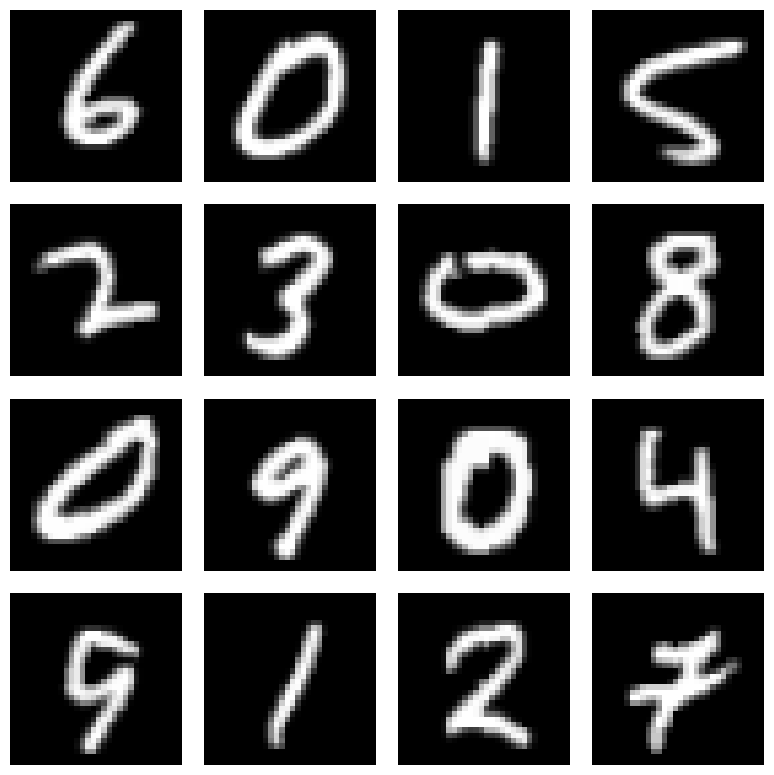

In [233]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(batch_size):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.show()

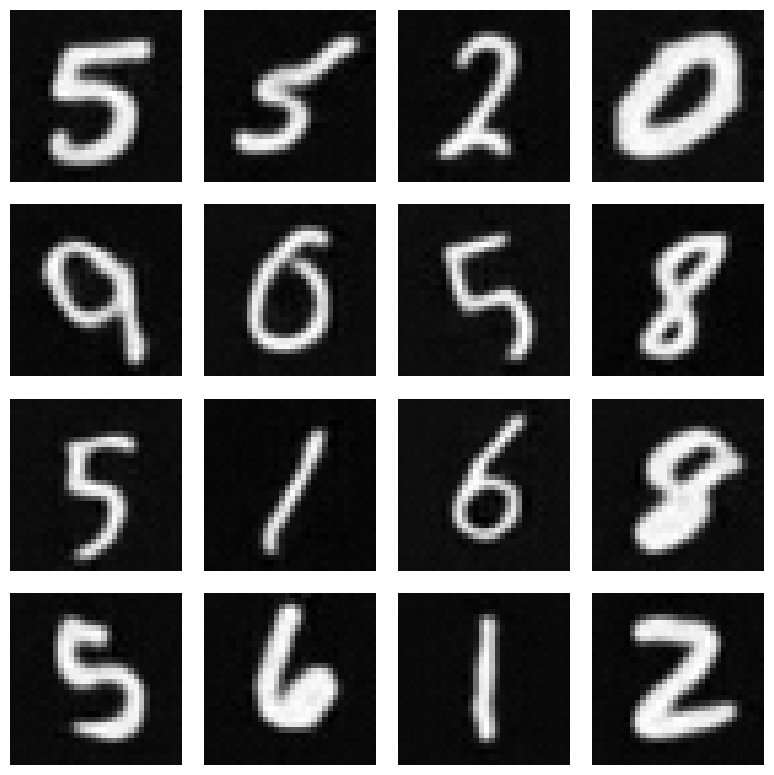

In [197]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(batch_size):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples_recon[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.show()

## Inspect samples from the trained model

torch.Size([16, 1, 8, 8])
torch.Size([16])


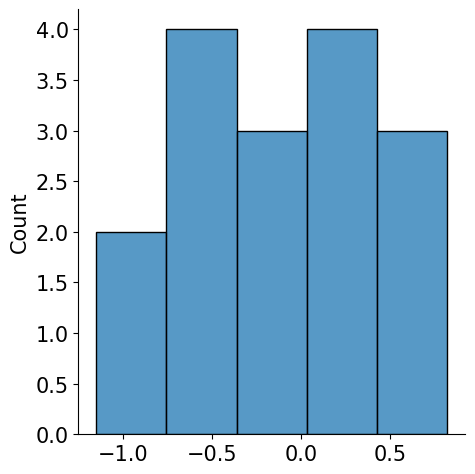

In [179]:
samples = model.bij_model.q0.sample(16) / 100

print(samples.shape)

# visualize vlatent
print(samples[:, 0, 0, 0].shape)
ax = sns.displot(samples[:, 0, 0, 0].detach().numpy())

tensor(-0.5756, grad_fn=<MinBackward1>) tensor(0.6326, grad_fn=<MaxBackward1>)
tensor(0.7756, grad_fn=<MaxBackward1>)
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SelectBackward0>)


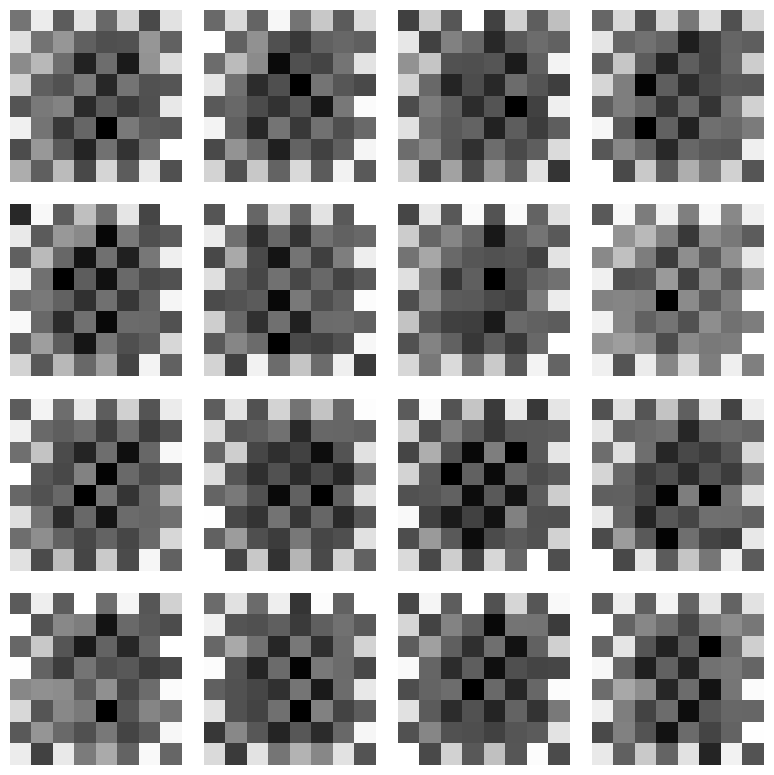

In [207]:
# samples = samples_recon
# Step 8: Generate Samples
num_samples = 16
model.eval()
# model = model.to(torch.device("cpu"))

# samples, _ = model.sample(num_samples)  # Generate samples
# samples, ldj = model.bij_model.sample(num_samples=num_samples) 
eps = torch.randn(
    (num_samples,) + model.bij_model.q0.shape, dtype=model.bij_model.q0.loc.dtype
)
temperature = 0.1
if temperature is None:
    log_scale = model.bij_model.q0.log_scale
else:
    log_scale = model.bij_model.q0.log_scale + np.log(temperature)
vlatent = model.bij_model.q0.loc + torch.exp(log_scale) * eps
# vlatent = torch.normal(mean=model.bij_model.q0.mu, std=model.bij_model.q0.std * 1.5, size=(num_samples,) + model.bij_model.q0.shape)
# model.bij_model.q0.sample(num_samples=num_samples) 100.
print(vlatent.min(), vlatent.max())
samples = model.bij_model(vlatent) 
print(samples.max())
samples = model.inj_model(samples )#/ samples.max())

# samples = model.inj_model.forward(samples)
samples = samples.view(-1, 1, 32, 32).cpu()  # Reshape for plotting

# Visualize generated samples
print(samples[0])

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(vlatent[i].squeeze().detach().numpy(),
               cmap="gray"
               )
    ax.axis("off")

plt.show()

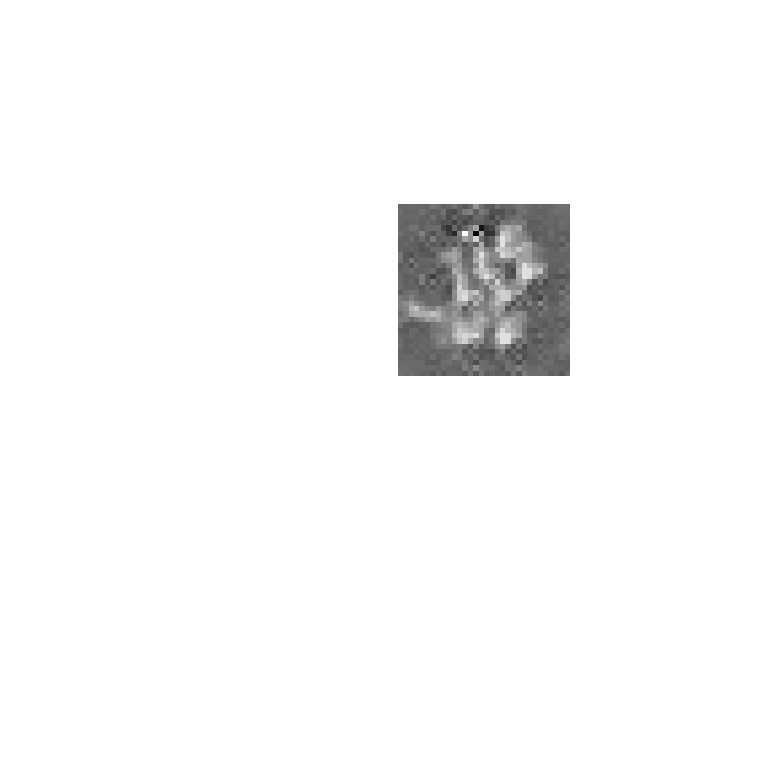

In [208]:
# samples = samples_recon.detach()

# Visualize generated samples
# grid_size = make_grid(samples, nrow=4, padding=2)
# save_image(grid_size, "generated_samples.png", normalize=True)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze().detach().numpy(),
               cmap="gray"
               )
    ax.axis("off")

plt.show()

## Inspect latent space of samples from MNIST

In [234]:
from ciflows.datasets.mnist import MNISTDataModule

root = Path('/Users/adam2392/pytorch_data/ciflows/vae/results/')

# Set up training configurations
batch_size = 1024
num_workers = 8
shuffle = True

# define the data loader
data_module = MNISTDataModule(
    data_dir=root,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)
data_module.setup('train')

In [261]:
dloader = data_module.train_dataloader()
samples, classes = next(iter(dloader))   
print(samples.shape)

torch.Size([1024, 1, 32, 32])


In [213]:
# reload the model from checkpoint
root = Path("/Users/adam2392/pytorch_data/ciflows/")
# root = Path('../results/')
model_dir = root / "injflow_twostage_batch1024_gradclip1_mnist_trainableq0_nstepsmse20_v2"
model_dir = root / "adamw_resnet_injflow_twostage_batch1024_gradclip1_mnist_trainableq0_nstepsmse20_v2"
# model_dir = root / "injflow_twostage_batch1024_gradclipNone_mnist_v1"
epoch = 992
step = 53622

model_fname = model_dir / f"epoch={epoch}-step={step}.ckpt"
# model_fname = model_dir / f"mse_chkpoint_20.ckpt"
model = plInjFlowModel.load_from_checkpoint(model_fname).to('cpu')

# print(len(model.get_injective_and_other_params()[0]))
print(model.current_epoch)

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'inj_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['inj_model'])`.
/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'bij_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['bij_model'])`.


0


In [264]:
print(samples.shape, samples.max(), samples.min())
print(torch.exp(model.bij_model.q0.log_scale))

log_prob = model.bij_model.q0.log_prob(v)
print(log_prob)

torch.Size([1024, 1, 32, 32]) tensor(1.) tensor(-1.)
tensor([[[[0.5269, 0.4420, 0.3304, 0.7151, 0.3492, 0.6362, 0.3090, 0.4380],
          [0.4428, 0.5468, 0.9247, 0.4418, 1.0404, 0.4757, 0.7151, 0.3053],
          [0.5511, 0.8494, 0.4679, 1.0455, 0.5294, 1.0289, 0.3586, 0.4503],
          [0.4665, 0.5575, 1.0472, 0.5406, 1.0584, 0.5183, 0.7460, 0.3029],
          [0.5524, 0.9622, 0.4658, 1.0650, 0.5167, 1.0291, 0.3387, 0.4496],
          [0.5381, 0.5620, 1.0317, 0.4939, 1.0454, 0.5309, 0.6505, 0.2987],
          [0.5541, 0.8032, 0.4559, 1.0462, 0.5647, 0.7787, 0.3064, 0.4383],
          [0.4422, 0.5789, 0.5988, 0.3499, 0.5127, 0.3049, 0.4371, 0.3019]]]],
       grad_fn=<ExpBackward0>)
tensor([-46.9731, -46.8020, -46.6487,  ..., -46.1466, -46.8697, -46.2793],
       grad_fn=<RsubBackward1>)


torch.Size([1024, 1, 8, 8])


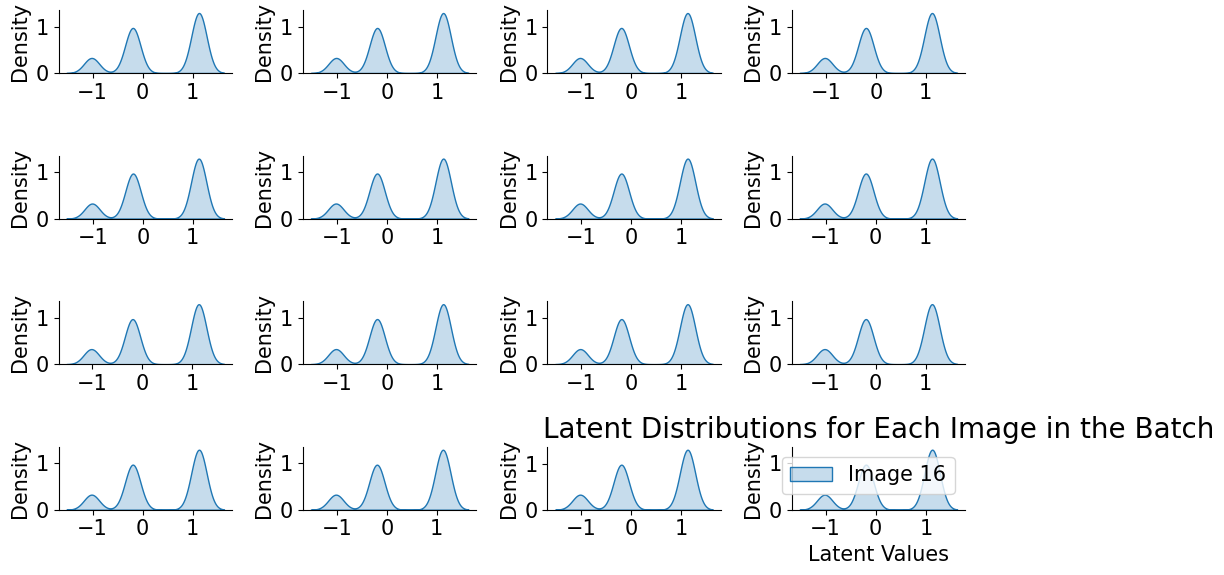

In [236]:
vlatent = model.inverse(samples)
v = model.inj_model.inverse(samples)
print(v.shape)
# Reshape the tensor to flatten the latent dimensions (1x8x8 -> 64) for each image
latent_tensor_flattened = v.view(16, -1).detach().numpy()

# Plot the distribution for each image
fig, axs = plt.subplots(4, 4, figsize=(10, 6), squeeze=True)
for i in range(16):
    sns.kdeplot(latent_tensor_flattened[i], label=f'Image {i+1}', fill=True, alpha=0.25, ax=axs[i // 4, i % 4])

plt.title('Latent Distributions for Each Image in the Batch')
plt.xlabel('Latent Values')
plt.ylabel('Density')
plt.legend(loc='best')
plt.show()

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_1620/940359674.py:9: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='best')
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_1620/940359674.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


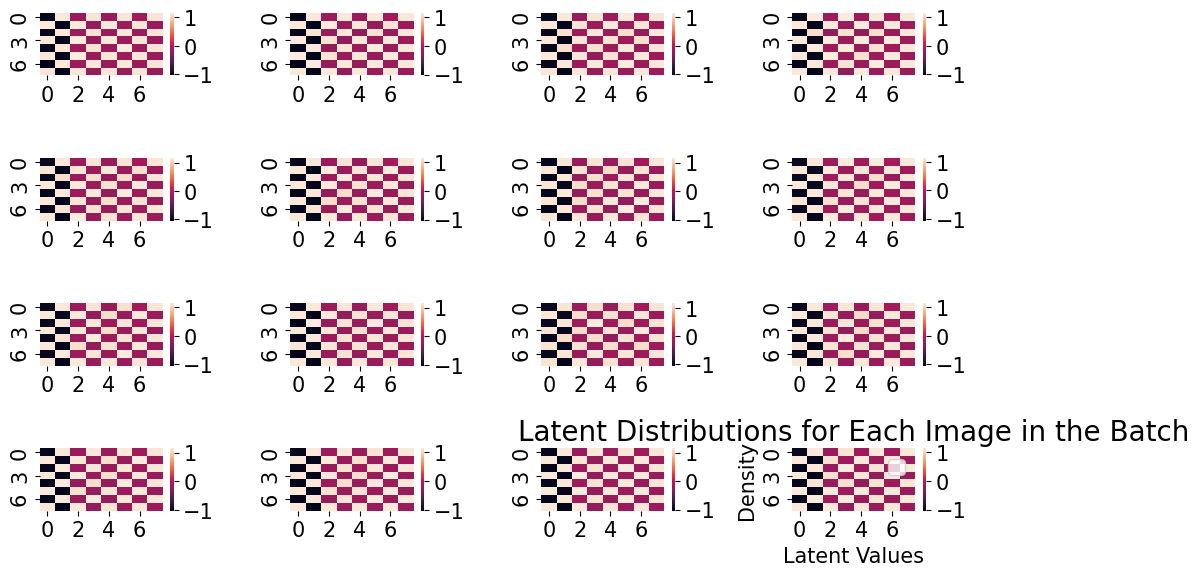

In [252]:
# Plot the distribution for each image
fig, axs = plt.subplots(4, 4, figsize=(10, 6), squeeze=True)
for i in range(16):
    sns.heatmap(v[i].detach().numpy().squeeze(), label=f'Image {i+1}', ax=axs[i // 4, i % 4])

plt.title('Latent Distributions for Each Image in the Batch')
plt.xlabel('Latent Values')
plt.ylabel('Density')
plt.legend(loc='best')
plt.show()

In [254]:
print(v[0] - v[1])

tensor([[[-1.1426e-03, -1.3468e-03, -4.3173e-03, -1.5888e-02, -5.3960e-04,
           7.6640e-04, -1.0777e-02, -4.9192e-03],
         [ 1.2047e-03,  3.7431e-03, -9.3628e-03, -2.8267e-02,  6.1158e-03,
           3.0140e-02,  2.7375e-02, -6.7465e-03],
         [-5.7050e-03,  2.8911e-02,  2.2700e-02, -3.0996e-02,  2.9807e-02,
           3.7880e-02, -1.2226e-02, -7.1720e-03],
         [-6.9480e-03,  2.8808e-03,  4.6397e-02,  9.9813e-03,  1.3857e-02,
          -3.9216e-03, -5.4028e-03, -1.1360e-03],
         [ 2.1914e-03,  6.4273e-03,  4.3890e-02, -9.4724e-03,  8.7842e-03,
           9.1803e-04, -2.9183e-03,  1.1436e-03],
         [-9.2680e-03,  1.0174e-02,  5.6728e-02, -5.2794e-03, -1.1882e-03,
           1.7161e-02, -1.3000e-02,  1.3743e-03],
         [ 4.4584e-05, -1.4807e-02,  2.7763e-02, -2.2984e-04,  1.8223e-02,
           5.4591e-03, -2.1352e-03, -2.8974e-03],
         [ 3.9725e-03, -7.2495e-03, -1.6643e-02,  1.7750e-04, -2.2703e-03,
          -8.0096e-03,  1.1754e-04, -2.0653e-05]]]

In [240]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(v.detach().numpy().reshape(batch_size, -1))

GaussianMixture(n_components=10)

(16, 64)


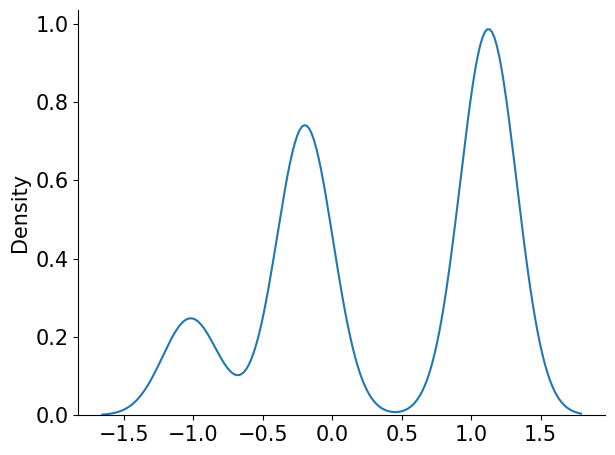

In [241]:

v_samples, _ = gmm.sample(16)
sns.kdeplot(v_samples.flatten())
print(v_samples.shape)

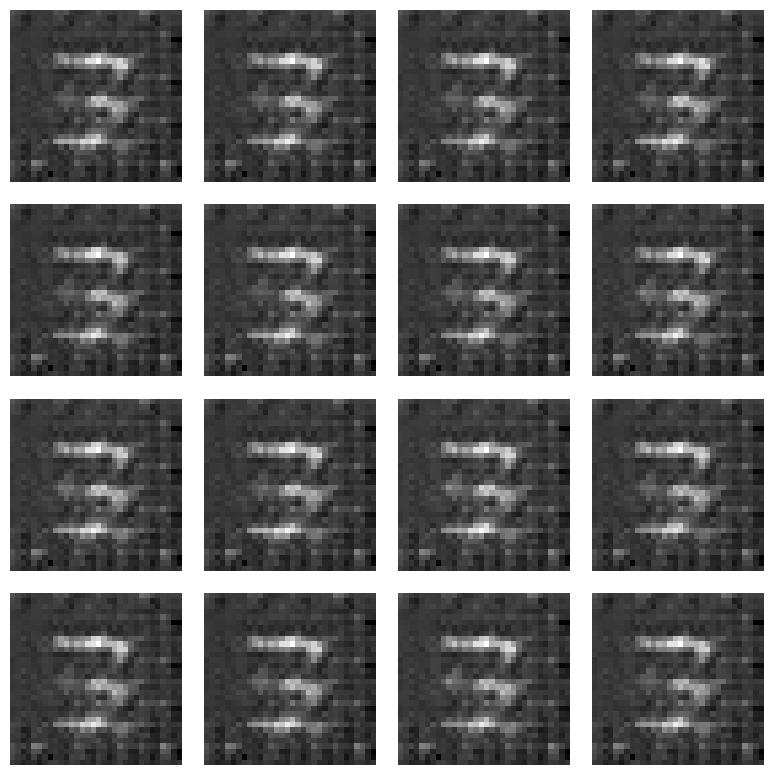

In [242]:
v_samples = torch.tensor(v_samples).float().view(16, 1, 8, 8)

x_samples = model.forward(v_samples)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(x_samples[i].squeeze().detach().numpy(),
               cmap="gray"
               )
    ax.axis("off")

plt.show()

# (Playground) Sample build a model and demonstrate it

In [71]:
def initialize_flow(model):
    """
    Initialize a full normalizing flow model
    """
    for name, param in model.named_parameters():
        if "weight" in name:
            # Layer-dependent initialization
            if "coupling" in name:
                nn.init.normal_(param, mean=0.0, std=0.01)
            else:
                nn.init.xavier_uniform_(param)
        elif "bias" in name:
            nn.init.constant_(param, 0.0)



In [23]:

def get_inj_model():
    use_lu = True
    gamma = 1e-6
    activation = "linear"

    n_hidden = 512
    n_glow_blocks = 3
    n_mixing_layers = 2
    n_injective_layers = 4
    n_layers = n_mixing_layers + n_injective_layers

    input_shape = (1, 32, 32)
    n_channels = input_shape[0]
    img_size = input_shape[1]

    n_chs = n_channels
    flows = []

    debug = False

    n_chs = int(n_channels * 4**n_mixing_layers * (1 / 2) ** n_injective_layers)
    print("Starting at latent representation: ", n_chs)
    latent_size = int(img_size / (2**n_mixing_layers))
    q0 = nf.distributions.DiagGaussian((n_chs, latent_size, latent_size))

    split_mode = "channel"

    for i in range(n_injective_layers):
        if i == 0:
            split_mode = "checkerboard"
        else:
            split_mode = "channel"

        for j in range(n_glow_blocks):
            flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                    split_mode=split_mode,
                )
            ]

        # input to inj flow is what is at the X -> V layer
        flows += [
            InjectiveGlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                activation=activation,
                scale=True,
                gamma=gamma,
                debug=debug,
                split_mode=split_mode,
            )
        ]
        n_chs = n_chs * 2
        if debug:
            print(f"On layer {n_layers - i}, n_chs = {n_chs//2} -> {n_chs}")

    for i in range(n_mixing_layers):
        for j in range(n_glow_blocks):
            flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                    split_mode=split_mode
                )
            ]
        flows += [Squeeze()]
        n_chs = n_chs // 4
        if debug:
            print(f"On layer {n_mixing_layers - i}, n_chs = {n_chs}")

    model = nf.NormalizingFlow(q0=q0, flows=flows)
    model.output_n_chs = n_chs
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    return model


def get_bij_model(n_chs, latent_size):
    use_lu = True
    n_hidden = 256
    n_glow_blocks = 6

    flows = []

    debug = False

    print("Starting at latent representation: ", n_chs, latent_size, latent_size)
    q0 = nf.distributions.DiagGaussian((n_chs, latent_size, latent_size))

    split_mode = "checkerboard"

    for i in range(n_glow_blocks):
        flows += [
            GlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                use_lu=use_lu,
                scale=True,
                split_mode=split_mode,
            )
        ]

        if debug:
            print(f"On layer {n_glow_blocks - i}, n_chs = {n_chs//2} -> {n_chs}")

    model = nf.NormalizingFlow(q0=q0, flows=flows)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)
    return model

In [25]:
inj_model = get_inj_model()
samples = inj_model.q0.sample(2)
_, n_chs, latent_size, _ = samples.shape
print(samples.shape)

bij_model = get_bij_model(n_chs=1, latent_size=8)
samples = bij_model(samples)
print(samples.shape)
# glow_block = GlowBlock(1, 64, use_lu=True, scale=True, split_mode='checkerboard')
# output, _ = glow_block.forward(samples)
# print(output.shape)

Starting at latent representation:  1
6649714
torch.Size([2, 1, 8, 8])
Starting at latent representation:  1 8 8
437912
torch.Size([2, 1, 8, 8])


In [100]:
# set seed
seed = 12345
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")
    accelerator = "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

debug = False
fast_dev = False
max_epochs = 1000
if debug:
    accelerator = "cpu"
    fast_dev = True
    max_epochs = 1

batch_size = 128
n_steps_mse = 500
devices = 1
strategy = "auto"  # or ddp if distributed
num_workers = 4
gradient_clip_val = None  # 1.0
check_val_every_n_epoch = 5
monitor = "val_loss"

lr = 3e-4
lr_min = 1e-8
lr_scheduler = "cosine"

# whether or not to shuffle dataset
shuffle = True

# output filename for the results
root = "./data/"
model_name = "check_injflow_mnist_v2"
checkpoint_dir = Path("./results") / model_name
checkpoint_dir.mkdir(exist_ok=True, parents=True)

model_fname = f"{model_name}-model.pt"

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    save_top_k=5,
    monitor=monitor,
    every_n_epochs=check_val_every_n_epoch,
)


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.info(f"\n\n\tsaving to {model_fname} \n")

# Define the trainer
trainer = pl.Trainer(
    logger=False,
    max_epochs=max_epochs,
    devices=devices,
    strategy=strategy,
    callbacks=[checkpoint_callback, TwoStageTraining()],
    check_val_every_n_epoch=check_val_every_n_epoch,
    accelerator=accelerator,
    # fast_dev_run=fast_dev,
    # log_every_n_steps=1,
    # max_epochs=1,
    # limit_train_batches=1,
    # limit_val_batches=1,
)

# define the model
flow_model = get_model()
initialize_flow(flow_model)
model = plInjFlowModel(
    flow_model,
    lr=lr,
    lr_min=lr_min,
    lr_scheduler=lr_scheduler,
    n_steps_mse=n_steps_mse,
)

Seed set to 12345
INFO:root:

	saving to check_injflow_mnist_v2-model.pt 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using device: mps
Using accelerator: mps
Starting at latent representation:  1
On layer 6, n_chs = 1 -> 2
On layer 5, n_chs = 2 -> 4
On layer 4, n_chs = 4 -> 8
On layer 3, n_chs = 8 -> 16
On layer 2, n_chs = 4
On layer 1, n_chs = 1
145694


/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [101]:

# sample the data
num_samples = 16
samples, _ = model.sample(num_samples)
print('Output images: ', samples.shape)

AffineCouplingBlock torch.Size([16, 1, 8, 8])
Injective1x1Conv torch.Size([16, 1, 8, 8])
ActNorm torch.Size([16, 2, 8, 8])
AffineCouplingBlock torch.Size([16, 2, 8, 8])
Injective1x1Conv torch.Size([16, 2, 8, 8])
ActNorm torch.Size([16, 4, 8, 8])
AffineCouplingBlock torch.Size([16, 4, 8, 8])
Injective1x1Conv torch.Size([16, 4, 8, 8])
ActNorm torch.Size([16, 8, 8, 8])
AffineCouplingBlock torch.Size([16, 8, 8, 8])
Injective1x1Conv torch.Size([16, 8, 8, 8])
ActNorm torch.Size([16, 16, 8, 8])
Output images:  torch.Size([16, 1, 32, 32])


torch.Size([3, 138, 138])


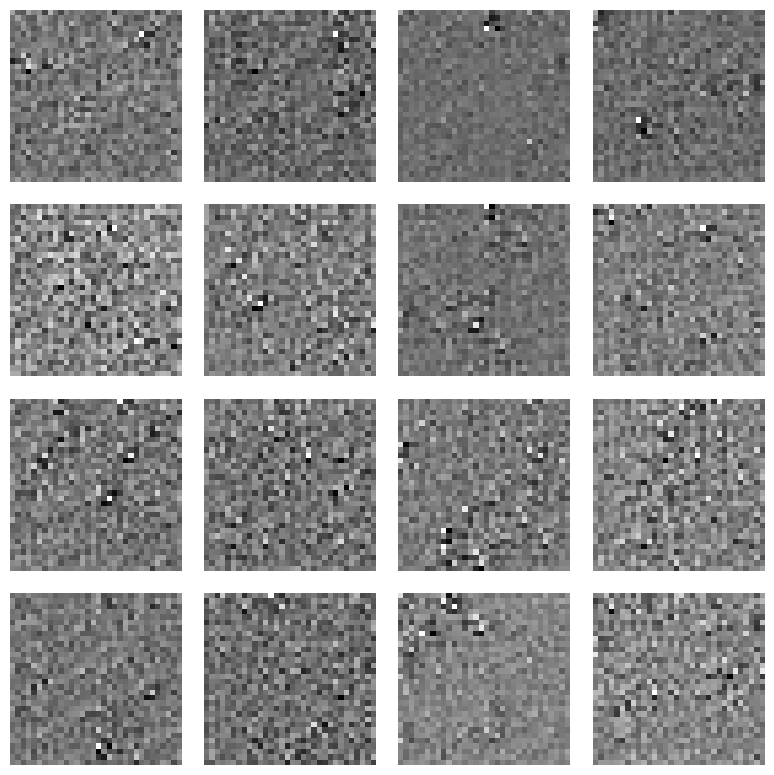

In [102]:
#  Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

In [ ]:
# inspect 